## Data

In [2]:
import sklearn
from sklearn.datasets import make_circles

In [3]:
n_samples = 1000 
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [4]:
print(X[:5])
print(y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


In [5]:
import pandas as pd 
circles = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})

circles.head(5)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


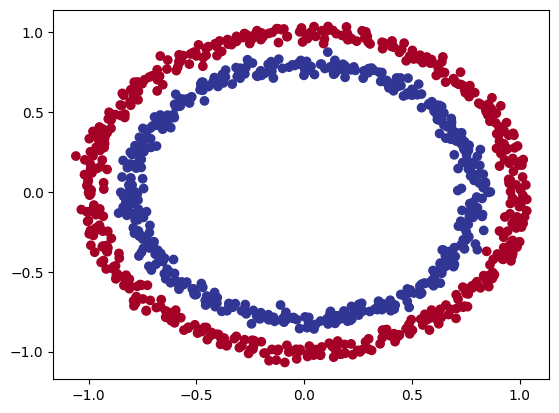

In [6]:
import matplotlib.pyplot as plt
plt.scatter(
    x=X[:, 0], 
    y=X[:, 1], 
    c=y, 
    cmap=plt.cm.RdYlBu
)

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### Turn data into tensors and create train and test split 

In [9]:
import torch 
from torch import nn

In [10]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, # 20% test, 80% train
    random_state=42
) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [13]:
class CircelModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_01 = nn.Linear(in_features=2, out_features=5)
        self.layer_02 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_02(self.layer_01, x)
    
model_0 = CircelModelV0().to(device)
model_0

CircelModelV0(
  (layer_01): Linear(in_features=2, out_features=5, bias=True)
  (layer_02): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
# replicate the CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
untrained_preds = model_0(X_test.to(device))

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.3381],
        [0.3406],
        [0.4958],
        [0.2927],
        [0.7567],
        [0.7562],
        [0.5565],
        [0.6545],
        [0.4846],
        [0.3436]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [16]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [17]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.3381],
        [0.3406],
        [0.4958],
        [0.2927],
        [0.7567]], device='cuda:0', grad_fn=<SliceBackward0>)

In [18]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5837],
        [0.5843],
        [0.6215],
        [0.5727],
        [0.6806]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [19]:
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

In [20]:
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [21]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(
    params=model_0.parameters(), 
    lr=0.1
)

torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train).squeeze() # squeeze to remove extra '1' dimension
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    loss = loss_fn(y_logits, y_train) 
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # testing
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f} % | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f} %")

Epoch: 0 | Loss: 0.73349 | Accuracy: 50.00 % | Test loss: 0.72213 | Test accuracy: 50.00 %
Epoch: 10 | Loss: 0.70230 | Accuracy: 50.00 % | Test loss: 0.69734 | Test accuracy: 50.00 %
Epoch: 20 | Loss: 0.69593 | Accuracy: 54.37 % | Test loss: 0.69263 | Test accuracy: 58.50 %
Epoch: 30 | Loss: 0.69457 | Accuracy: 51.00 % | Test loss: 0.69181 | Test accuracy: 52.50 %


Epoch: 40 | Loss: 0.69422 | Accuracy: 49.75 % | Test loss: 0.69172 | Test accuracy: 53.50 %
Epoch: 50 | Loss: 0.69407 | Accuracy: 49.00 % | Test loss: 0.69175 | Test accuracy: 53.00 %
Epoch: 60 | Loss: 0.69398 | Accuracy: 48.75 % | Test loss: 0.69179 | Test accuracy: 53.50 %
Epoch: 70 | Loss: 0.69390 | Accuracy: 48.62 % | Test loss: 0.69184 | Test accuracy: 53.00 %
Epoch: 80 | Loss: 0.69383 | Accuracy: 48.75 % | Test loss: 0.69189 | Test accuracy: 53.50 %
Epoch: 90 | Loss: 0.69377 | Accuracy: 48.88 % | Test loss: 0.69193 | Test accuracy: 53.50 %


In [22]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


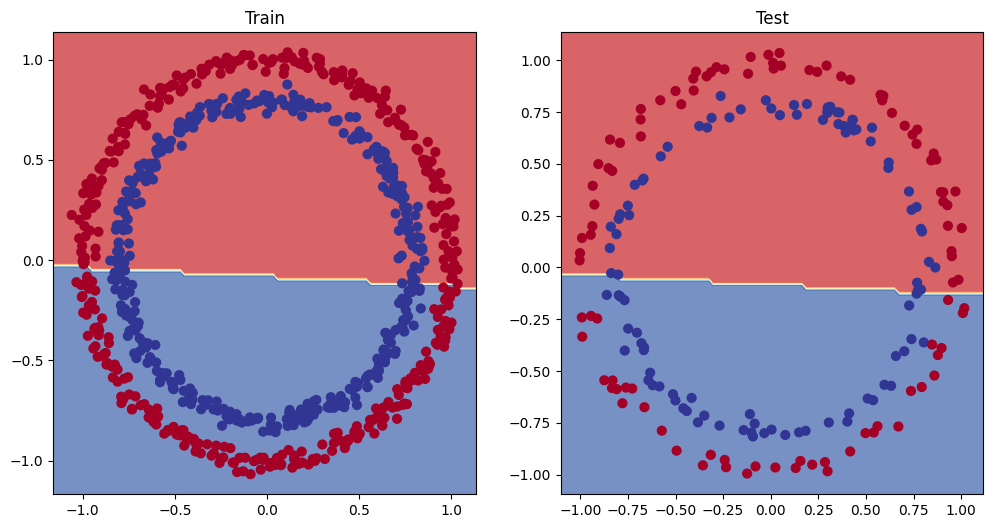

In [23]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [24]:
class CircelModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        z = self.relu(self.layer_1(x))
        z = self.relu(self.layer_2(z))
        z = self.layer_3(z)
        return z
    
model_1 = CircelModelV1().to(device)
model_1

CircelModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [39]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [40]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [41]:
# Fit the model
torch.manual_seed(42)
epochs = 1500

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%
Epoch: 1000 | Loss: 0.56818, Accuracy: 87.75% | Test Loss: 0.57378, Test Accuracy: 86.50%
Epoch: 1100 | Loss: 0.

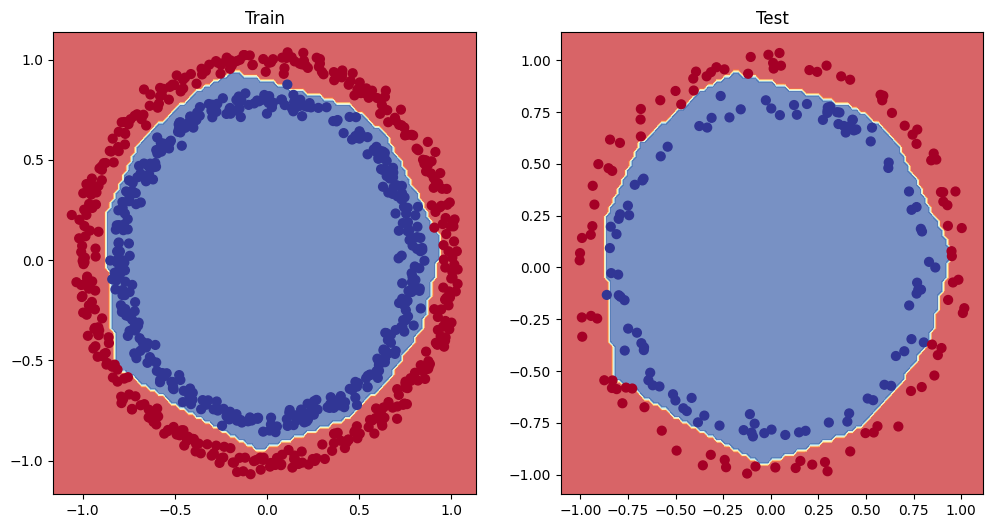

In [43]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## Replicating non-linear activation functions

In [50]:
A = torch.arange(-10, 10, 1.0)
A.dtype

torch.float32

In [51]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

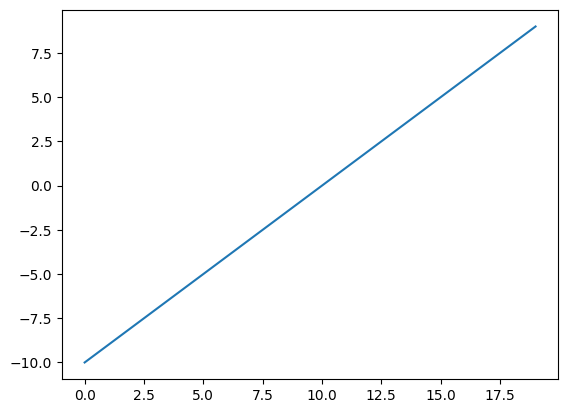

In [52]:
plt.plot(A)

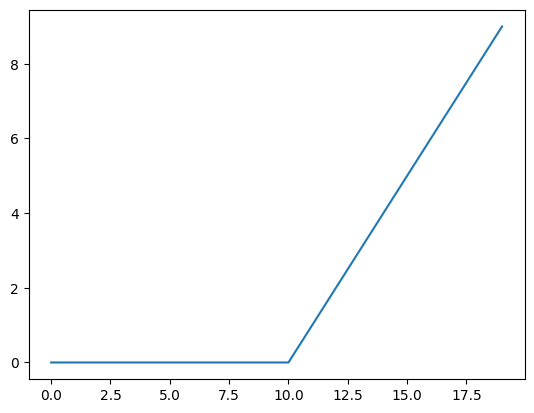

In [53]:
plt.plot(torch.relu(A))

In [54]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x) # input must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

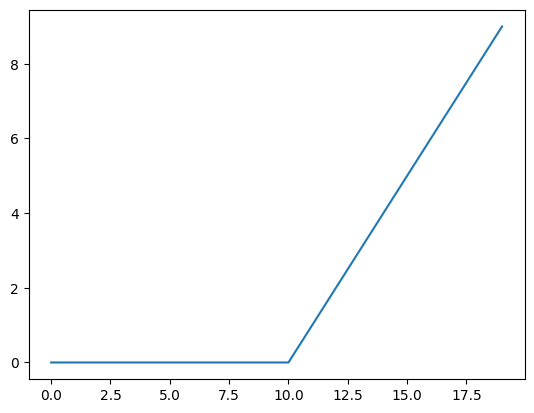

In [55]:
plt.plot(relu(A))

In [56]:
def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-x))

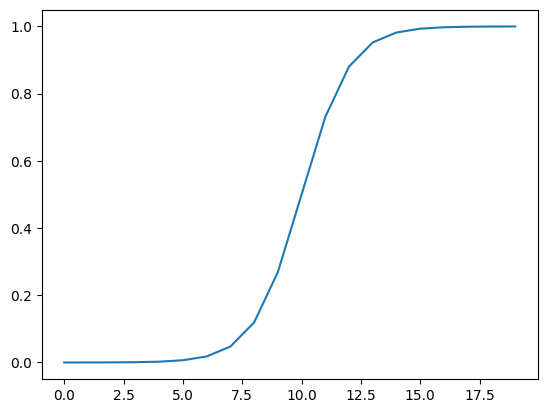

In [58]:
plt.plot(torch.sigmoid(A))

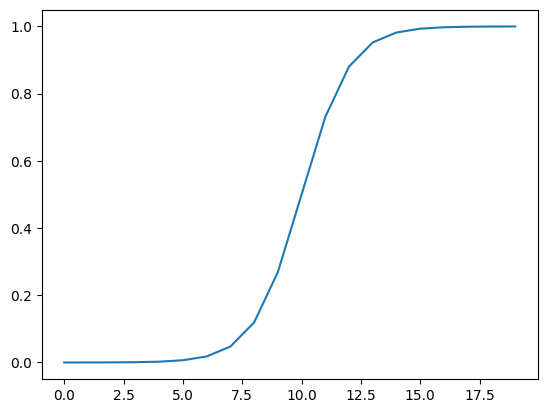

In [59]:
plt.plot(sigmoid(A))

## Multiclass classification

In [60]:
import torch 
import matplotlib.pyplot as plt 
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [62]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [111]:
# 1. Create multi-class data
X_blob, y_blob = make_blobs(
    n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


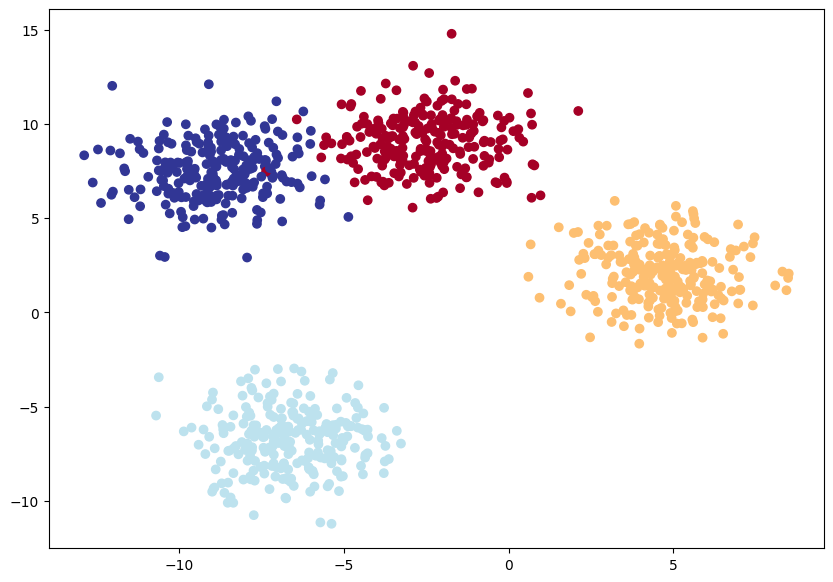

In [112]:
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [113]:
devivce = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [137]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidded_units=8):
        """Multiclass classification model for detecting blobs of toy dataset"""
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidded_units),
            #nn.ReLU(),
            nn.Linear(in_features=hidded_units, out_features=hidded_units),
            #nn.ReLU(),
            nn.Linear(in_features=hidded_units, out_features=output_features)
        )
        
    def forward(self, x):
        return self.linear_layer_stack(x)

In [138]:
model_4 = BlobModel(
    input_features=NUM_FEATURES,
    output_features=NUM_CLASSES, 
    hidded_units=8
).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [139]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model_4.parameters(), 
    lr=0.01
)

In [140]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_train.to(device))[:5]
y_logits

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], device='cuda:0')

In [141]:
y_pred_probs = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

print(y_pred_probs[:5])
print(y_blob_test[:5])

tensor([1, 3, 2, 2, 3], device='cuda:0')
tensor([1, 3, 2, 1, 0], device='cuda:0')


In [142]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

epochs = 100

for epoch in range(epochs):
    # Training 
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(
        y_true=y_blob_train,
        y_pred=y_pred
    )

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(
            y_true=y_blob_test,
            y_pred=test_preds
        )

    # Print what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f} | Acc: {acc:.2f} % | Test loss: {test_loss:.4f} | Test acc: {test_acc:.2f} %")

Epoch: 0 | Loss: 1.0432 | Acc: 65.50 % | Test loss: 0.9634 | Test acc: 71.00 %
Epoch: 10 | Loss: 0.6369 | Acc: 79.50 % | Test loss: 0.6122 | Test acc: 88.00 %
Epoch: 20 | Loss: 0.4694 | Acc: 97.75 % | Test loss: 0.4586 | Test acc: 98.00 %
Epoch: 30 | Loss: 0.3734 | Acc: 98.50 % | Test loss: 0.3677 | Test acc: 99.00 %
Epoch: 40 | Loss: 0.3101 | Acc: 98.62 % | Test loss: 0.3066 | Test acc: 99.00 %
Epoch: 50 | Loss: 0.2649 | Acc: 98.88 % | Test loss: 0.2623 | Test acc: 99.00 %
Epoch: 60 | Loss: 0.2308 | Acc: 98.88 % | Test loss: 0.2285 | Test acc: 99.50 %
Epoch: 70 | Loss: 0.2043 | Acc: 99.12 % | Test loss: 0.2020 | Test acc: 99.50 %
Epoch: 80 | Loss: 0.1831 | Acc: 99.12 % | Test loss: 0.1806 | Test acc: 99.00 %
Epoch: 90 | Loss: 0.1658 | Acc: 99.12 % | Test loss: 0.1630 | Test acc: 99.00 %


In [143]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
accuracy = accuracy_fn(y_blob_test, y_preds)

print(f"Got accuracy of: {accuracy}")

Got accuracy of: 99.0


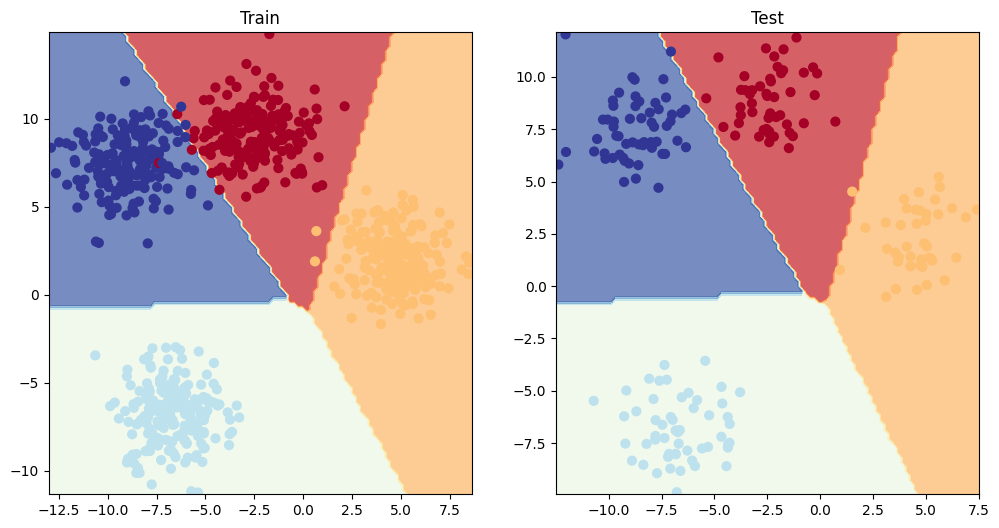

In [144]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)